In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_union
from sklearn.compose import make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config; set_config(display='diagram')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

In [2]:
## Load CSV
path_from = "raw_data/full_data_clean.csv"
df = pd.read_csv(path_from, delimiter=',', low_memory=False, encoding = 'utf-8')

## Build PCA Pipeline

In [10]:
## Split Data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train= df.loc[:2000000,:]
X_train.shape

(2000001, 23)

In [11]:
num_transformer = make_pipeline(RobustScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))

preprocess = make_column_transformer((num_transformer, ['Item Price']), 
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region']))

In [12]:
## Transform Data
preprocess.fit(X_train)
X_train_trans= preprocess.transform(X_train)

In [13]:
## PCA Process
pca = PCA()
pca.fit(X_train_trans)
X_proj = pca.transform(X_train_trans)
X_proj = pd.DataFrame(X_proj)

## KMeans

In [14]:
## Modelling
km = KMeans(n_clusters=4)
km.fit(X_proj)

## Extend Cluster to initial DF
# df['Cluster'] = km.labels_

KMeans(n_clusters=4)

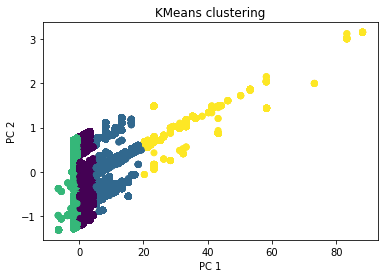

In [15]:
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

In [66]:
## Save new defined Clusters
# df.to_csv('raw_data/full_data_clean_inclCluster.csv')

Text(0.5, 0, 'k cluster number')

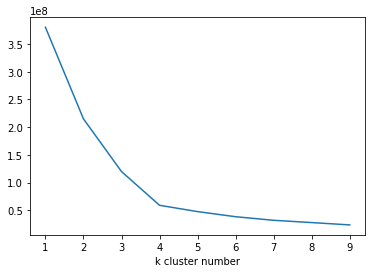

In [67]:
## Calculate optimal Cluster-Size
inertias = []
ks = range(1,10)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_proj)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

In [17]:
df.head()

,Unnamed: 0,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,Item Last Supplying Date,...,Date,Count Ratings,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type
0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,2022-03-01 00:00:00,...,2019-01-01 00:00:00,0,20,2,20,0.00,0 days 00:50:00,1545,french,urban
1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,2019-06-27 00:00:00,...,2019-01-01 00:00:00,1,0,9,16,4.00,0 days 04:00:00,237,german,urban
2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,2019-06-27 00:00:00,...,2019-01-02 00:00:00,8,0,28,33,4.25,0 days 04:00:00,237,german,urban
3,3,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,2019-06-27 00:00:00,...,2019-01-27 00:00:00,0,10,11,17,0.00,0 days 04:00:00,237,german,urban
4,4,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,2019-06-27 00:00:00,...,2019-01-31 00:00:00,1,10,13,17,5.00,0 days 04:00:00,237,german,urban
